# Analise Feature Space

### Load library and load datas

In [ ]:
import glob
import sys
import os
import copy
import math
from tqdm import tqdm
tqdm.pandas(desc='DataFrame Operation')
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import svm
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time


In [ ]:
import plotly.express as px
pd.options.display.float_format = '{:,.2f}'.format
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [ ]:
from numpy import set_printoptions
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

In [ ]:
# Cloud authentication.
from google.colab import auth
from google.colab import drive

auth.authenticate_user()
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [5]:
path_base = '/content/drive/MyDrive/ROIs_Joined_All'
lstfiles = glob.glob(path_base + '/*')
for cc, npath in enumerate(lstfiles):
    print(f"#{cc} >> {npath}")

#0 >> /content/drive/MyDrive/ROIs_Joined_All/7615.csv
#1 >> /content/drive/MyDrive/ROIs_Joined_All/7619.csv
#2 >> /content/drive/MyDrive/ROIs_Joined_All/765.csv
#3 >> /content/drive/MyDrive/ROIs_Joined_All/7712.csv
#4 >> /content/drive/MyDrive/ROIs_Joined_All/773.csv
#5 >> /content/drive/MyDrive/ROIs_Joined_All/7746.csv
#6 >> /content/drive/MyDrive/ROIs_Joined_All/7438.csv
#7 >> /content/drive/MyDrive/ROIs_Joined_All/752.csv
#8 >> /content/drive/MyDrive/ROIs_Joined_All/7584.csv
#9 >> /content/drive/MyDrive/ROIs_Joined_All/7591.csv
#10 >> /content/drive/MyDrive/ROIs_Joined_All/761111.csv


In [6]:

dict_class = {
    '3': 'Forest formation',
    '4': 'Savanna Formation',
    '12': 'Grassland',
    '15': 'Pasture',
    '18': 'Agriculture',
    '21': 'Mosaic of Use',
    '22': 'Non vegetated Area',
    '29': 'Rocky Outcrop',
    '33': 'Water'
}
dict_color = {
    '3':  "#1F8D49",
    '4':  "#7DC975",
    '12': "#D6BC74",
    '15': "#EDDE8E",
    '18': "#E974ED",
    '21': "#FFEFC3",
    '22': "#D4271E",
    '29': '#FFAA5F',
    '33': "#0000FF"
}

### Load Table

In [46]:
def get_coordenadas(row):
    # '{"type":"Point","coordinates":[-44.97462246781868,-17.08205447417011]}'
    coord = row['.geo']
    partes = coord.split(",")
    row['Longitude'] = float(partes[1].replace('"coordinates":[', ''))
    row['Latitude'] = float(partes[2].replace(']}', ''))
    return row

print(" we load >> ", lstfiles[6])
newdf = pd.read_csv(lstfiles[6])
# newdf = newdf.drop(['system:index','.geo'], axis=1)
newdf = newdf.progress_apply(get_coordenadas, axis= 1)

display(newdf.head())

 we load >>  /content/drive/MyDrive/ROIs_Joined_All/7438.csv


DataFrame Operation: 100%|██████████| 78785/78785 [00:55<00:00, 1411.69it/s]


system:index  GRID_ID  afvi_median  afvi_median_dry  \
0  00000000000000000000     6327         0.45             0.43   
1  00000000000000000001     6327         0.45             0.43   
2  00000000000000000002     6327         0.45             0.43   
3  00000000000000000003     6327         0.45             0.43   
4  00000000000000000004     6327         0.45             0.43   

   afvi_median_wet  avi_median  avi_median_dry  avi_median_wet  awei_median  \
0             0.48        0.01            0.01            0.01        -1.42   
1             0.48        0.01            0.01            0.01        -1.42   
2             0.48        0.01            0.01            0.01        -1.42   
3             0.48        0.01            0.01            0.01        -1.42   
4             0.48        0.01            0.01            0.01        -1.42   

   awei_median_dry  ...  ui_median  ui_median_dry  ui_median_wet  \
0            -1.50  ...      -0.14          -0.11          -0.17   
1            -1.50  ...      -0.14          -0.11          -0.17   
2            -1.50  ...      -0.14          -0.11          -0.17   
3            -1.50  ...      -0.14          -0.11          -0.17   
4            -1.50  ...      -0.14          -0.11          -0.17   

   wetness_median  wetness_median_dry  wetness_median_wet  year  \
0            0.46                0.48                0.44  2023   
1            0.46                0.48                0.44  2023   
2            0.46                0.48                0.44  2023   
3            0.46                0.48                0.44  2023   
4            0.46                0.48                0.44  2023   

                                                .geo  Longitude  Latitude  
0  {"type":"Point","coordinates":[-44.97462246781...     -44.97    -17.08  
1  {"type":"Point","coordinates":[-44.97462246781...     -44.97    -17.08  
2  {"type":"Point","coordinates":[-44.97462246781...     -44.97    -17.08  
3  {"type":"Point","coordinates":[-44.97462246781...     -44.97    -17.08  
4  {"type":"Point","coordinates":[-44.97462246781...     -44.97    -17.08  

[5 rows x 115 columns]

In [15]:
newdf['.geo'].tolist()[:5]

['{"type":"Point","coordinates":[-44.97462246781868,-17.08205447417011]}',
 '{"type":"Point","coordinates":[-44.97462246781868,-17.08205447417011]}',
 '{"type":"Point","coordinates":[-44.97462246781868,-17.08205447417011]}',
 '{"type":"Point","coordinates":[-44.97462246781868,-17.08205447417011]}',
 '{"type":"Point","coordinates":[-44.97462246781868,-17.08205447417011]}']

###Process data

In [8]:
def set_name_from_class(row):
    numCC = int(row['class'])
    row['name_class'] = dict_class[str(numCC)]
    return row

# newdf = newdf.progress_apply(set_name_from_class, axis= 1)

In [16]:
text = ''
for cc, col in enumerate(newdf.columns):
    if (cc + 1) % 5 == 0:
        print(text)
        text = ""
    else:
        text += '"' + str(col) + '",'
print(text)

"system:index","GRID_ID","afvi_median","afvi_median_dry",
"avi_median","avi_median_dry","avi_median_wet","awei_median",
"awei_median_wet","blue_median","blue_median_dry","blue_median_wet",
"brba_median","brba_median_dry","brba_median_wet","brightness_median",
"brightness_median_wet","bsi_median","bsi_median_1","bsi_median_2",
"cvi_median","cvi_median_dry","cvi_median_wet","dswi5_median",
"dswi5_median_wet","evi_median","evi_median_dry","evi_median_wet",
"gcvi_median_dry","gcvi_median_wet","gemi_median","gemi_median_dry",
"gli_median","gli_median_dry","gli_median_wet","green_median",
"green_median_wet","green_stdDev","gvmi_median","gvmi_median_dry",
"hillshade","iia_median","iia_median_dry","iia_median_wet",
"lswi_median_dry","lswi_median_wet","mbi_median","mbi_median_dry",
"nddi_median","nddi_median_dry","nddi_median_wet","ndvi_median",
"ndvi_median_wet","ndwi_median","ndwi_median_dry","ndwi_median_wet",
"nir_median_contrast","nir_median_dry","nir_median_dry_contrast","nir_median_wet",

In [47]:
print(newdf['class'].unique())
display(newdf['class'].value_counts())

[ 3  4 12 15 18 21 22]


class
4     40215
15    22890
3      7665
12     5565
21     2030
22      315
18      105
Name: count, dtype: int64

In [23]:
newdf = newdf.sort_values(by='year')
newdf['year'] = newdf['year'].astype(str)

### Plot series de dados

In [24]:
def make_plot_Bar(dftmp, colX, colY, title, lstClass):
    fig = go.Figure()
    # fig = make_subplots(specs=[[{"secondary_y": True}]])
    #  = [3,4]  #, 4, 12, 15, 18, 21, 22, 33
    for nclass in lstClass:
        fig.add_trace(go.Scatter(
            y=dftmp[dftmp['class'] == nclass][colY],
            x=dftmp[dftmp['class'] == nclass][colX],
            name= dict_class[str(nclass)],
            marker_color= dict_color[str(nclass)],
            mode= "markers",
        )) # , secondary_y=False

    fig.update_layout(
        title_text=title,
        title_font_size= 20,
        # barmode='stack',
        height= 450,
        width= 950,
        xaxis=dict(
            title="Anos",
            # tickangle=60,
            tickfont=dict(size=10),
            linecolor='black',
        ),
        yaxis=dict(
            title= colY,
            tickfont=dict(size=10),
            showticklabels=True,
            linecolor='black',
            # mirror= True,
            # tickformat = '.0f',
            # ticksuffix=" ha"
        ),
        font= dict(size=11),
        legend= dict(orientation="h", x= 0.15,  y=-0.2),
        plot_bgcolor='white',  # Define o fundo do gráfico como branco
        # paper_bgcolor='white',  # Define o fundo do papel como branco
    )

    # fig.update_yaxes(title_text="Column2", secondary_y=False)
    # fig.update_yaxes(title_text="Área em Hectare", secondary_y=True)
    fig.show()

In [20]:
listaCC = [3,4,12,21]  #, 4, 12, 15, 18, 21, 22, 33
indice = "evi_median"
make_plot_Bar(newdf, "year", indice, f"Distribuição de amostras X Class in {indice}", listaCC)

In [ ]:
listaCC = [3]  #, 4, 12, 15, 18, 21, 22, 33
indice = "evi_median"
make_plot_Bar(newdf, "year", indice, f"Distribuição de amostras X Class in {indice}", listaCC)

In [ ]:
listaCC = [12]  #, 4, 12, 15, 18, 21, 22, 33
indice = "evi_median"
make_plot_Bar(newdf, "year", indice, f"Distribuição de amostras X Class in {indice}", listaCC)

In [ ]:
listaCC = [15,18,21,22,33]  #, 4, 12, 15, 18, 21, 22, 33
indice = "evi_median"
make_plot_Bar(newdf, "year", indice, f"Distribuição de amostras X Class in {indice}", listaCC)

In [ ]:
listaCC = [21, 22]  #, 4, 12, 15, 18, 21, 22, 33
indice = "evi_median"
make_plot_Bar(newdf, "year", indice, f"Distribuição de amostras X Class in {indice}", listaCC)

In [ ]:
listaCC = [21, 18]  #, 4, 12, 15, 18, 21, 22, 33
indice = "evi_median"
make_plot_Bar(newdf, "year", indice, f"Distribuição de amostras X Class in {indice}", listaCC)

### Filters Data by values threholds

In [48]:
# Get table with class com EVI > 2 e EVI < 3
lstColsInt = [
    "evi_median","evi_median_dry","evi_median_wet",
    "osavi_median","osavi_median_dry","osavi_median_wet",
    "ndvi_median","ndvi_median_wet",
    "gcvi_median_dry","gcvi_median_wet",
    'class', 'Latitude','Longitude',
]
dfFiltered = newdf[(newdf[indice] > 0.2) & (newdf[indice] < 0.3)][lstColsInt]
print(dfFiltered.columns)
print(dfFiltered.shape)

Index(['evi_median', 'evi_median_dry', 'evi_median_wet', 'osavi_median',
       'osavi_median_dry', 'osavi_median_wet', 'ndvi_median',
       'ndvi_median_wet', 'gcvi_median_dry', 'gcvi_median_wet', 'class',
       'Latitude', 'Longitude'],
      dtype='object')
(48195, 13)


In [49]:
display(dfFiltered['class'].value_counts())

class
4     23940
15    16835
12     4025
3      1645
21     1365
22      315
18       70
Name: count, dtype: int64

In [45]:
dfFiltered.to_csv(lstfiles[6].replace('.csv', '_filtradaEVI_02_03.csv'))

In [ ]:
columns_features = [
           "system:index","GRID_ID","afvi_median","afvi_median_dry",
            "avi_median","avi_median_dry","avi_median_wet","awei_median",
            "awei_median_wet","blue_median","blue_median_dry","blue_median_wet",
            "brba_median","brba_median_dry","brba_median_wet","brightness_median",
            "brightness_median_wet","bsi_median","bsi_median_1","bsi_median_2",
            "cvi_median","cvi_median_dry","cvi_median_wet","dswi5_median",
            "dswi5_median_wet","evi_median","evi_median_dry","evi_median_wet",
            "gcvi_median_dry","gcvi_median_wet","gemi_median","gemi_median_dry",
            "gli_median","gli_median_dry","gli_median_wet","green_median",
            "green_median_wet","green_stdDev","gvmi_median","gvmi_median_dry",
            "hillshade","iia_median","iia_median_dry","iia_median_wet",
            "lswi_median_dry","lswi_median_wet","mbi_median","mbi_median_dry",
            "nddi_median","nddi_median_dry","nddi_median_wet","ndvi_median",
            "ndvi_median_wet","ndwi_median","ndwi_median_dry","ndwi_median_wet",
            "nir_median_contrast","nir_median_dry","nir_median_dry_contrast","nir_median_wet",
            "osavi_median","osavi_median_dry","osavi_median_wet","ratio_median",
            "ratio_median_wet","red_median","red_median_contrast","red_median_dry",
            "red_median_wet","red_stdDev","ri_median","ri_median_dry",
            "rvi_median","rvi_median_1","rvi_median_wet","shape_median",
            "shape_median_wet","solpe","swir1_median","swir1_median_dry",
            "swir1_stdDev","swir2_median","swir2_median_dry","swir2_median_wet",
            "ui_median","ui_median_dry","ui_median_wet","wetness_median",
            "wetness_median_wet","year",".geo",
        ]
classe = "class"
featureTest = ['blue', 'blue_1','blue_median', 'blue_median_dry', 'blue_stdDev']
featureTest2 = ['iia', 'iia_median', 'iia_median_dry']

In [ ]:
len(columns_features)

94

In [ ]:
feature_imp = [
    'blue_median', 'blue_median_dry', 'blue_stdDev', 'red_stdDev',
    'red_median','nir_median', 'nir_stdDev', 'swir1_median', 'swir1_stdDev',
    'swir2_stdDev', 'ndwi', 'iia', 'ndvi', 'cvi', 'cvi_median',
    'cvi_median_dry', 'rvi', 'rvi_median', 'rvi_median_dry',
    'gcvi', 'ratio_median', 'npv', 'npv_median', 'npv_median_dry',
    'ndfia', 'ndfia_median', 'ndfia_median_dry', 'soil', 'soil_median',
    'soil_median_dry', 'gv', 'gv_median', 'gv_median_dry'
]
bloco1 = ['gv_median','npv_median','soil_median','npv_amp','swir1_median']

In [ ]:
valquant = conta['blue_median'].values
valquant

array([12364, 91776,  8899,  4765, 10246,  2002,   213])

NameError: name 'valquant' is not defined

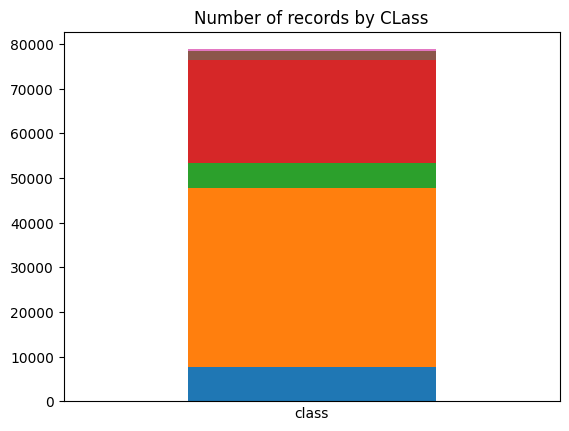

In [ ]:
newdf.assign(dummy = 1).groupby(
  ['dummy','class']
).size().to_frame().unstack().plot(kind='bar',stacked=True,legend=False)
plt.title('Number of records by CLass')
# other it'll show up as 'dummy'
plt.xlabel('class')
# disable ticks in the x axis
plt.xticks([])
# fix the legend
current_handles, _ = plt.gca().get_legend_handles_labels()
reversed_handles = reversed(current_handles)

labels =[str(kk) + ' <=> '+ str(valquant[cc]) for cc,  kk in enumerate(newdf['class'].unique())]
labels.sort(reverse=True)
plt.legend(reversed_handles,labels,loc='lower left',bbox_to_anchor=(1.1, 0.05), ncol=2)
plt.show()


In [ ]:
# Create an array with the colors you want to use
colors = ["#006400","#00ff00","#B8AF4F","#FFD966","#E974ED","#EA9999","#665a3a"]
# Set your custom color palette
sns.set_palette(sns.color_palette(colors))

dict_class = {
    '3': 'Forest formation',
    '4': 'Savanna Formation',
    '12': 'Grassland',
    '15': 'Pasture',
    '18': 'Agriculture',
    '22': 'Non vegetated Area',
#     '29': 'Rocky Outcrop',
    '33': 'Water'
}
markersplot = ["o","s","^","p","X","*","d"]  # ,"<"


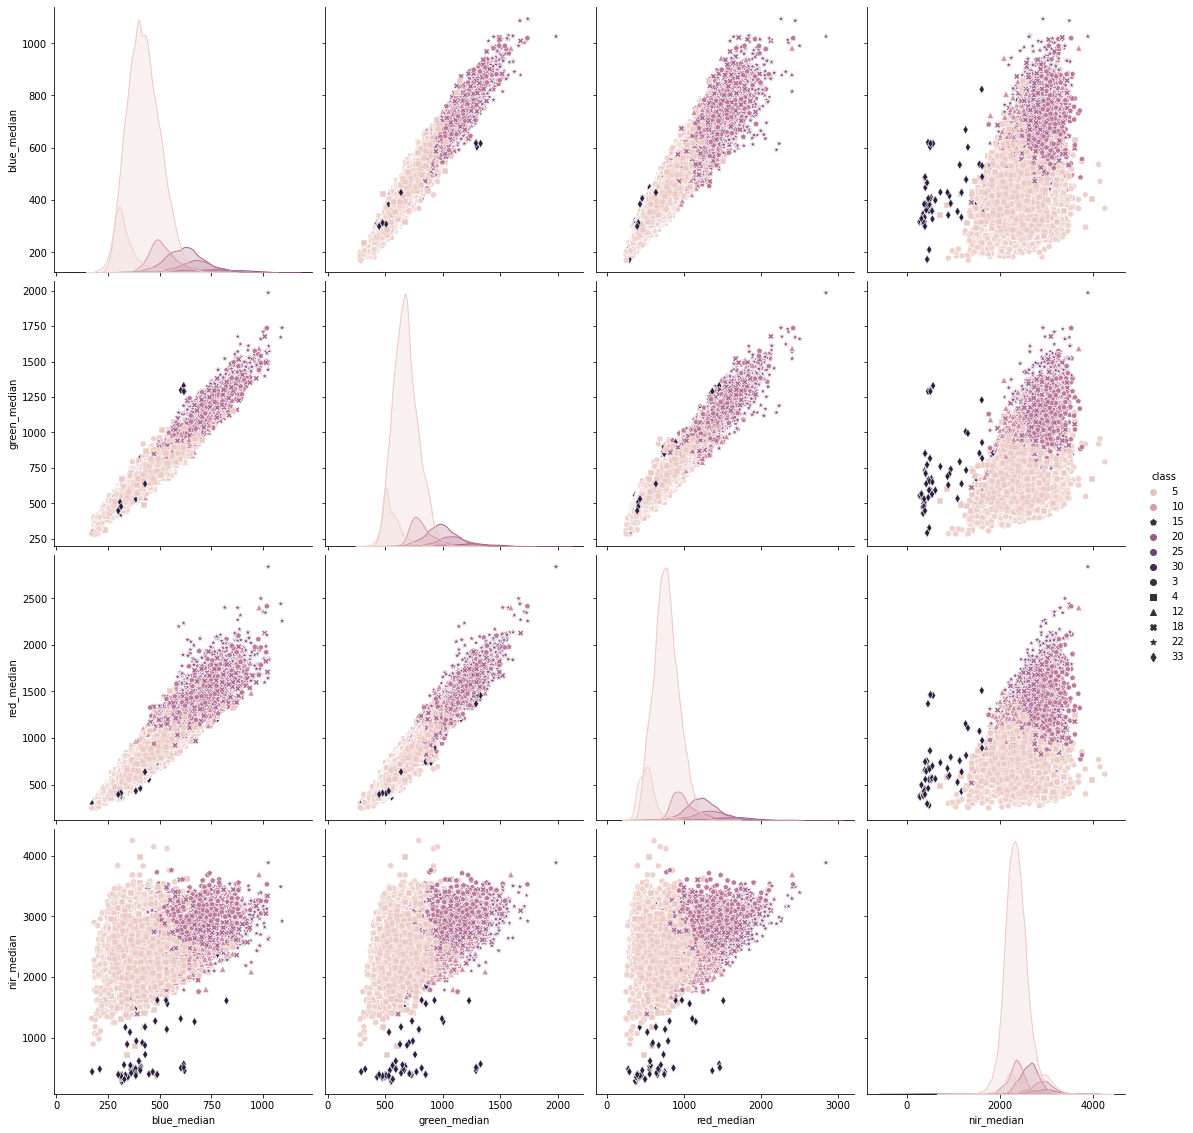

In [ ]:
bloco1 = ['blue_median','green_median','red_median','nir_median']
sns.pairplot(vars=bloco1, data= concat_df, hue='class', height=4, markers= markersplot)
sns.set_context("notebook", font_scale=1.5)  #

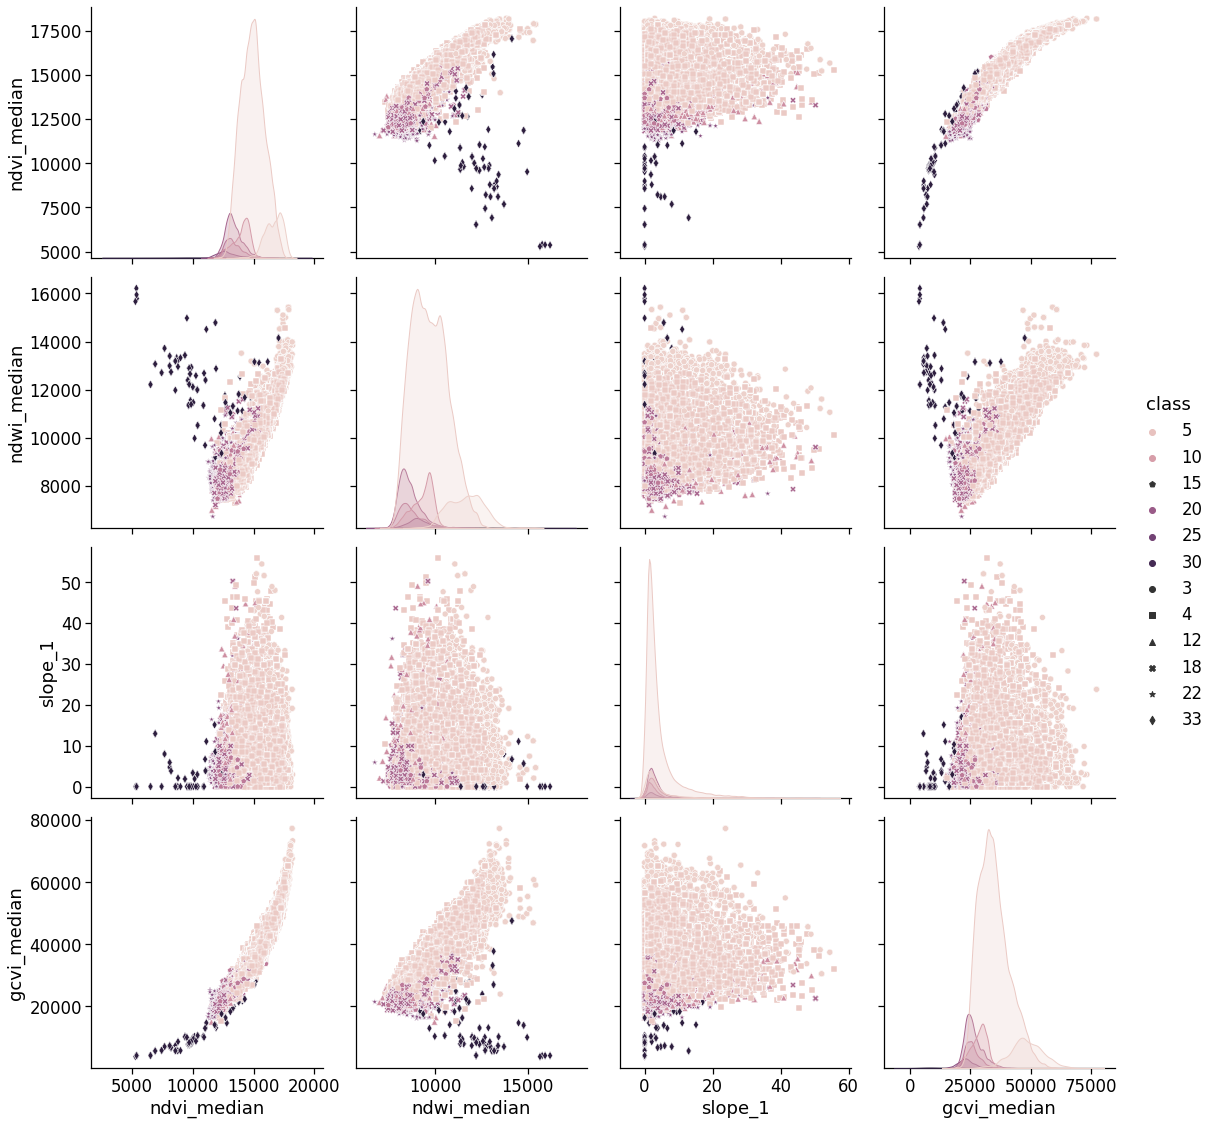

In [ ]:
bloco1 = ['ndvi_median','ndwi_median','slope_1','gcvi_median']
sns.pairplot(vars=bloco1, data= concat_df, hue='class', height=4, markers= markersplot)
sns.set_context("notebook", font_scale=1.5)  #

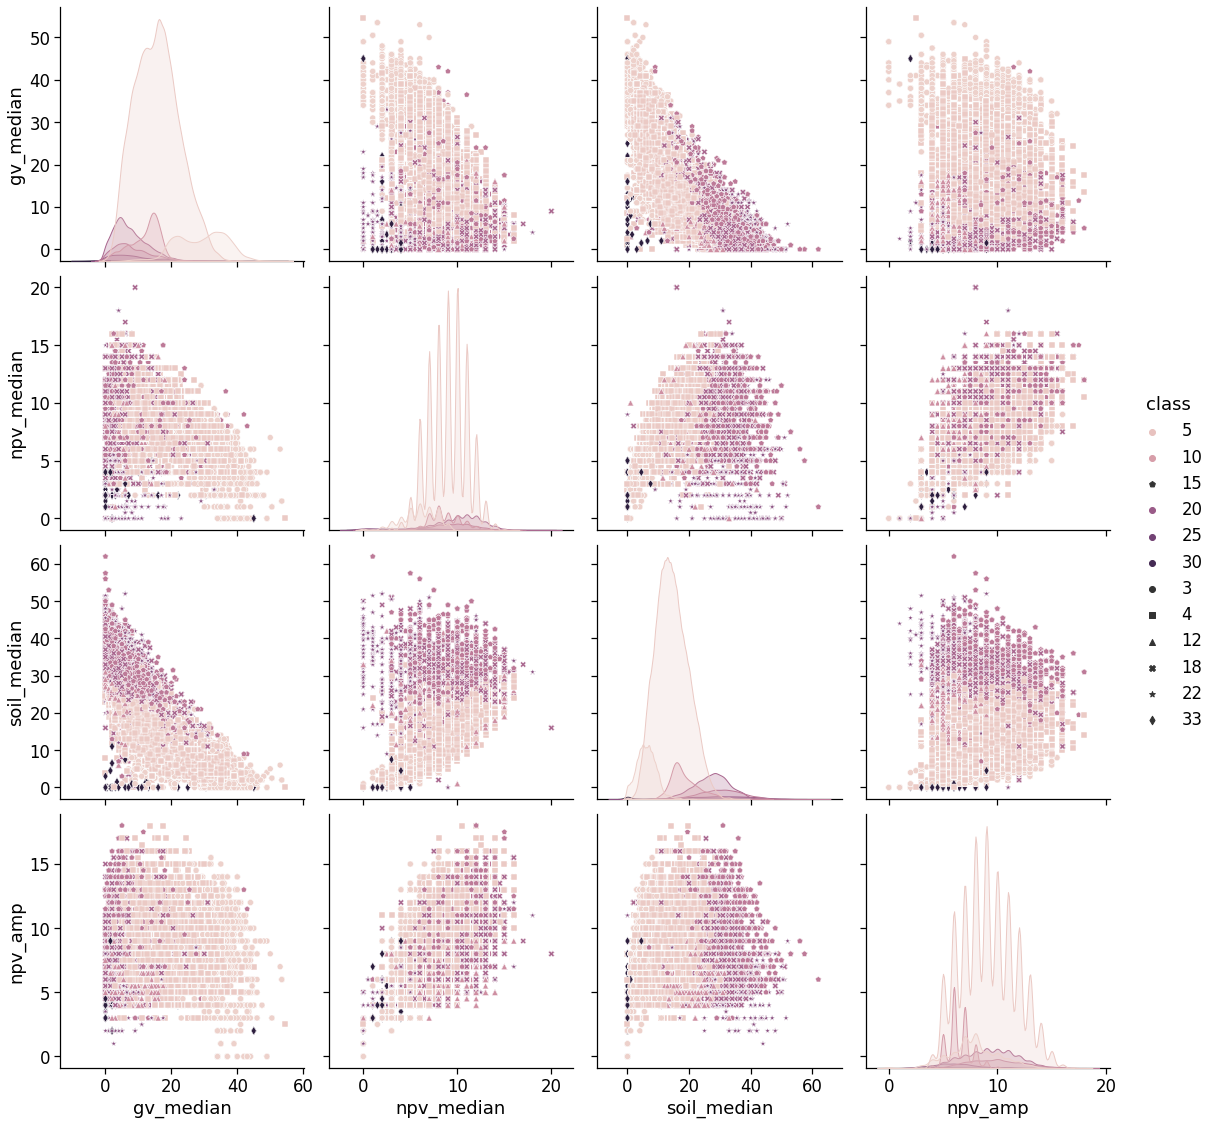

In [ ]:
bloco1 = ['gv_median','npv_median','soil_median','npv_amp']
sns.pairplot(vars=bloco1, data= concat_df, hue='class', height=4, markers= markersplot)
sns.set_context("notebook", font_scale=1.5)  #

In [ ]:
from random import randint
colunas_index = [
                    'blue_median','green_median','red_median','nir_median',
                    'ndvi_median','ndwi_median','slope_1','gcvi_median',
                    'gv_median','npv_median','soil_median','npv_amp'
                ]

In [ ]:
def ploting_violin_rois_Class_index (featA):

    fig , axes = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(18, 9))
    # Set your custom color palette
    sns.set_palette(sns.color_palette(colors))
    ladoA = sns.boxplot(x="class", y=featA, data=concat_df, ax= axes[0])  # , palette="Set3"
    ladoB = sns.violinplot(x="class", y=featA, data=concat_df,ax= axes[1], split=True, linestyle=':',  #  palette="Set3",
                        scale="count", inner="quartile")
    # sns.catplot(x="label", y="shade", data=ndf, palette="Set3")  # ax= axes[2],
    ladoA.set_xlabel("CLASS",fontsize=16)
    ladoA.set_ylabel(featA,fontsize=16)
    ladoB.set_xlabel("CLASS",fontsize=16)
    ladoB.set_ylabel(featA,fontsize=16)
    ladoA.set_xticklabels(dict_class.values(), rotation=45)
    ladoB.set_xticklabels(dict_class.values(), rotation=45)

    plt.suptitle('Plot ROIs class in {}'.format(featA), fontsize=24)
    plt.show()

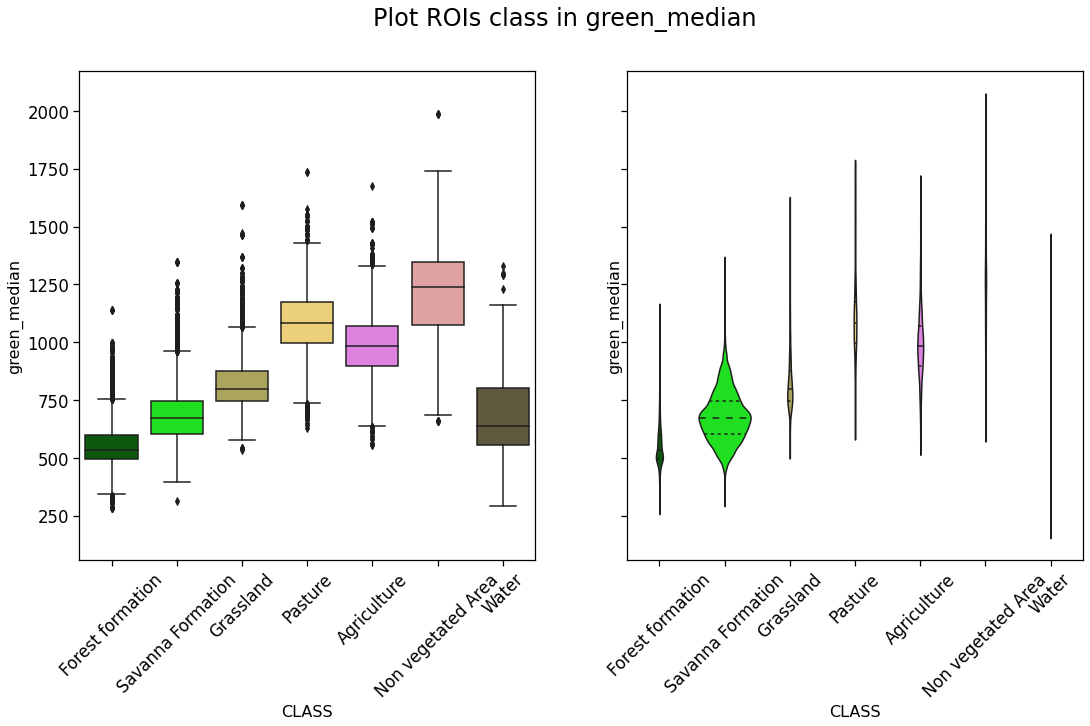

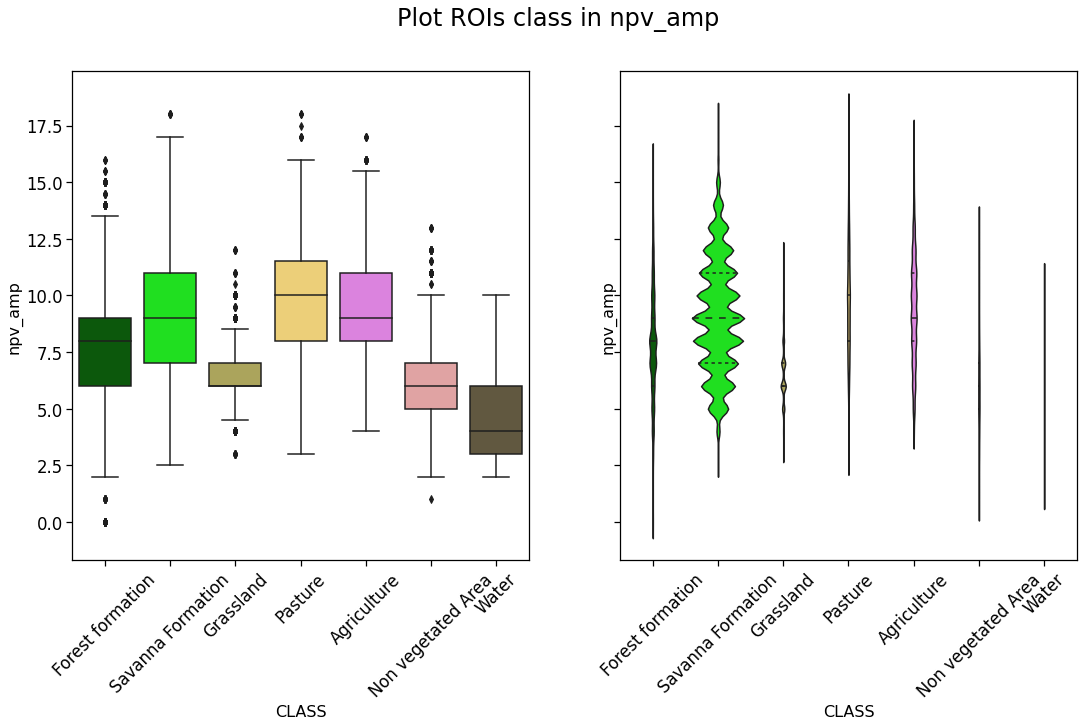

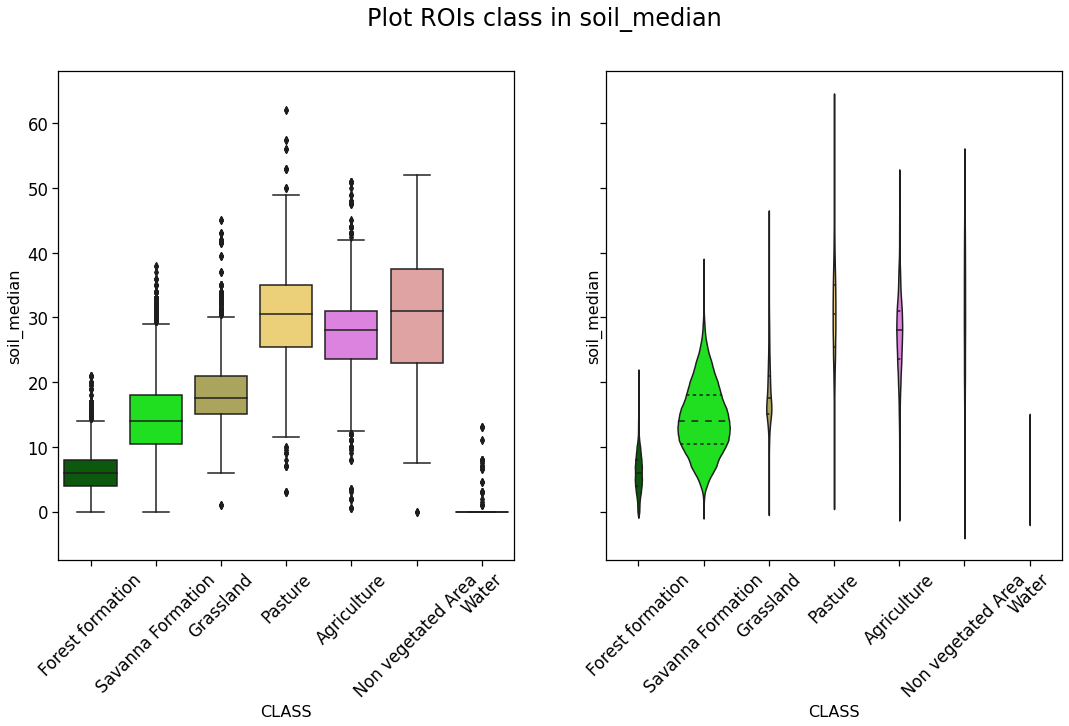

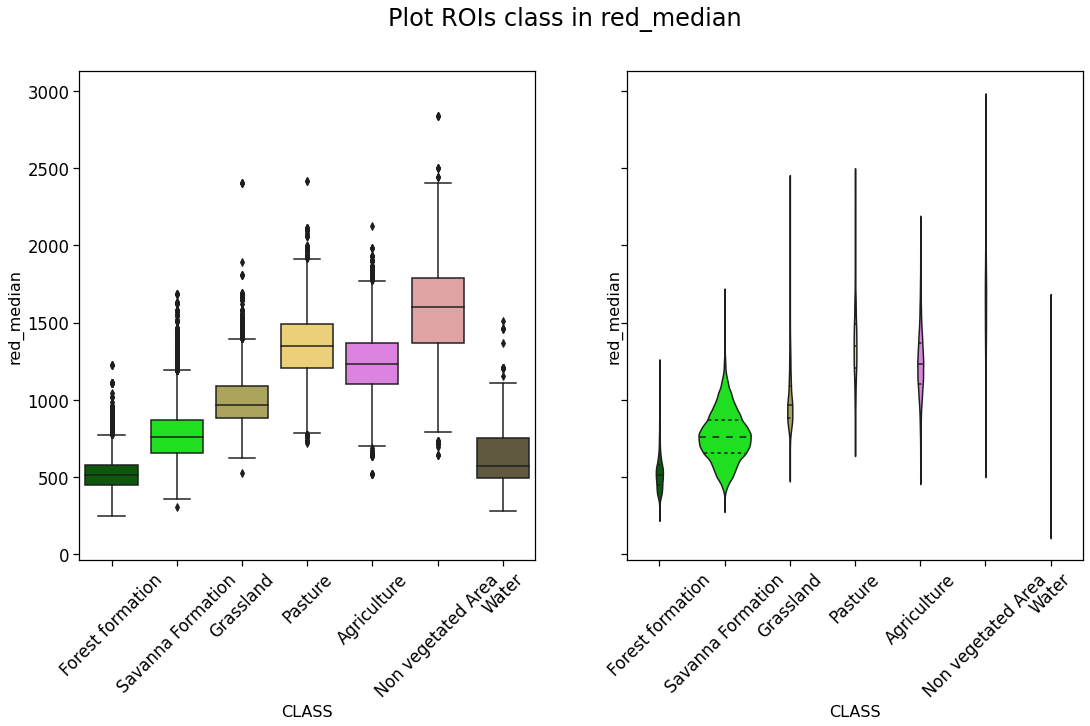

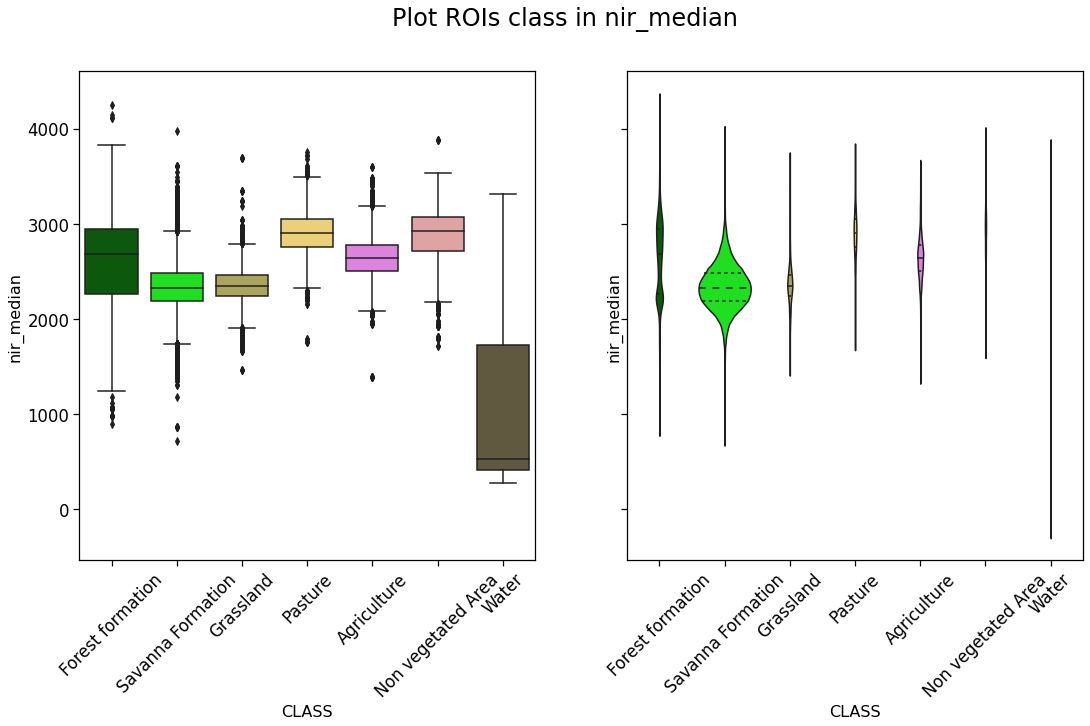

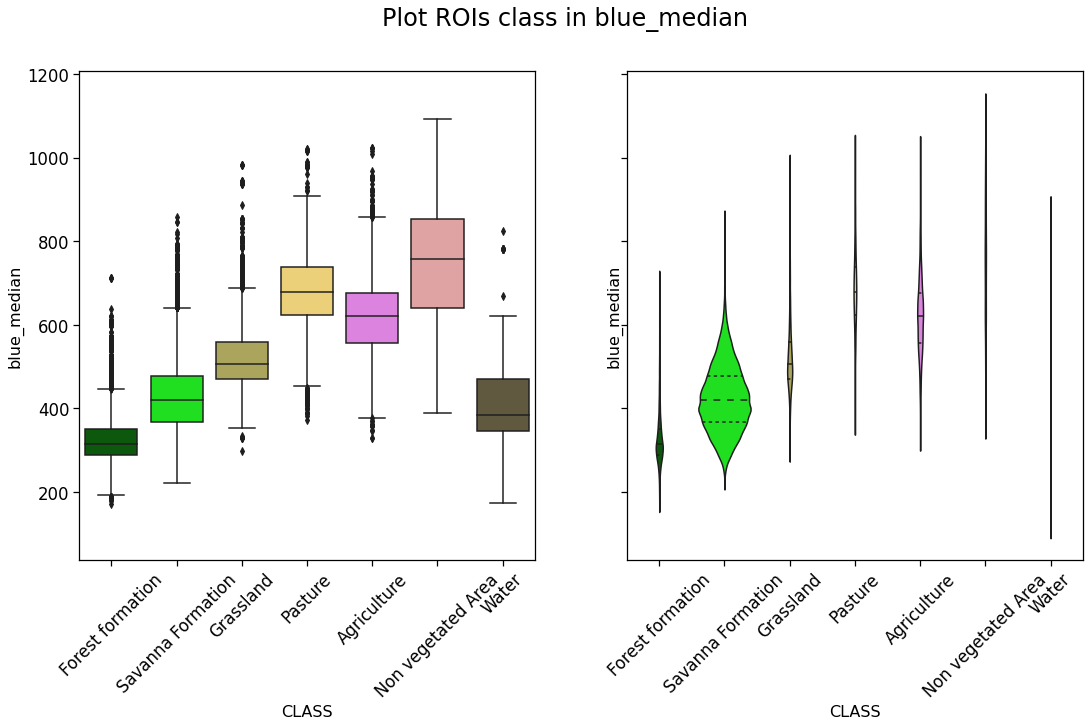

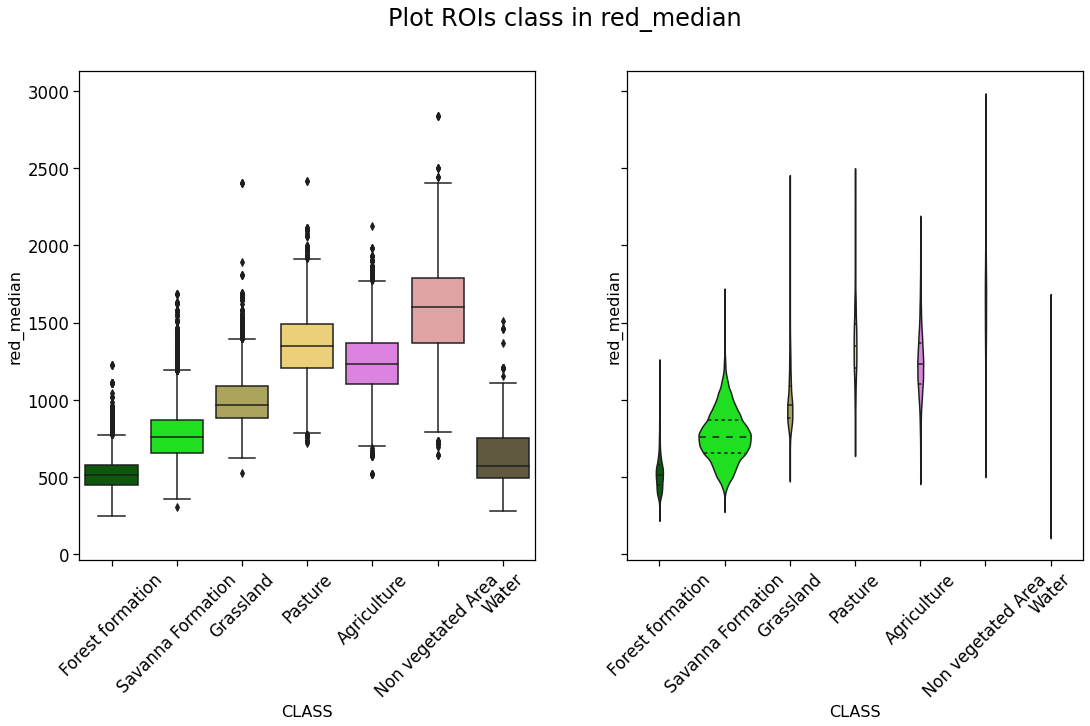

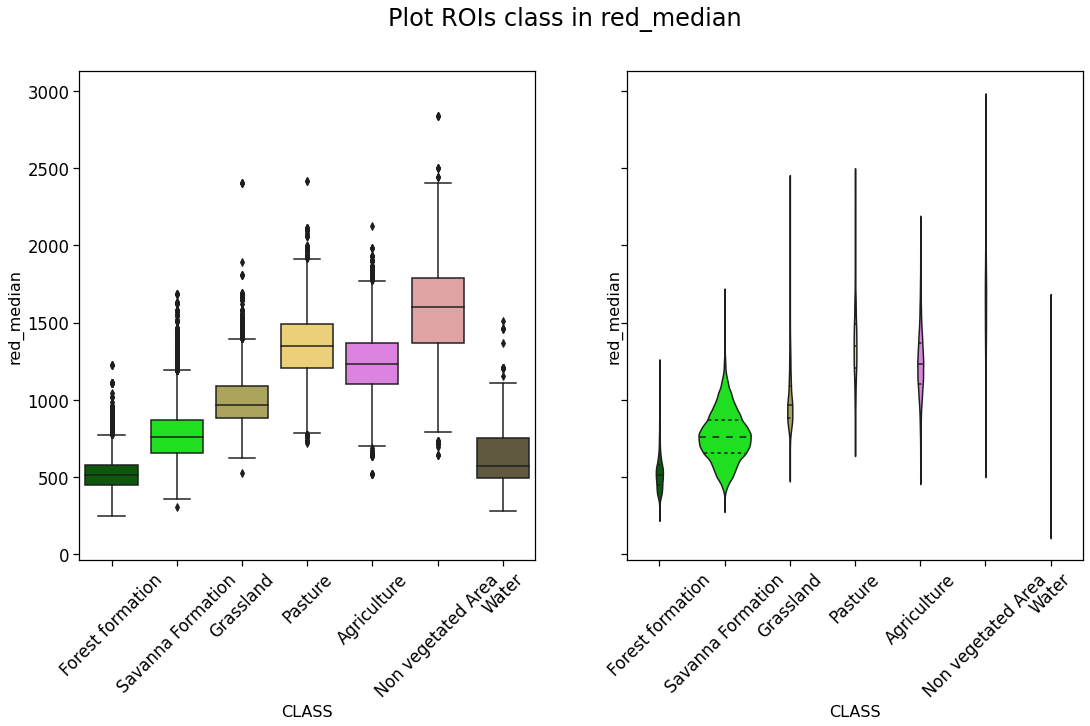

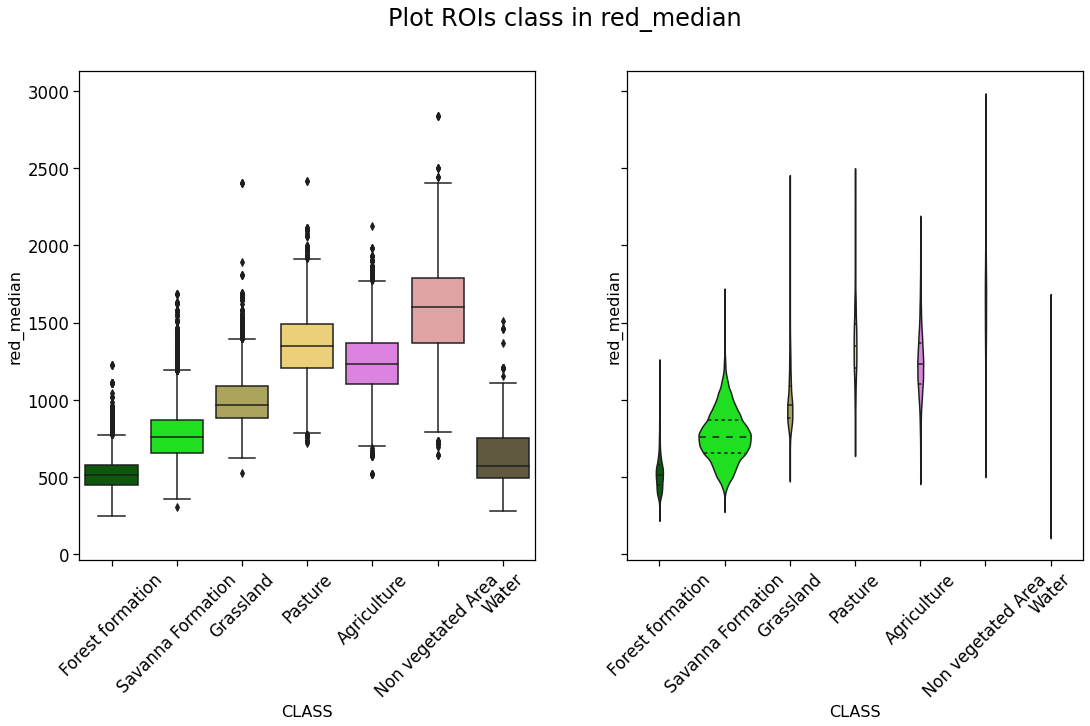

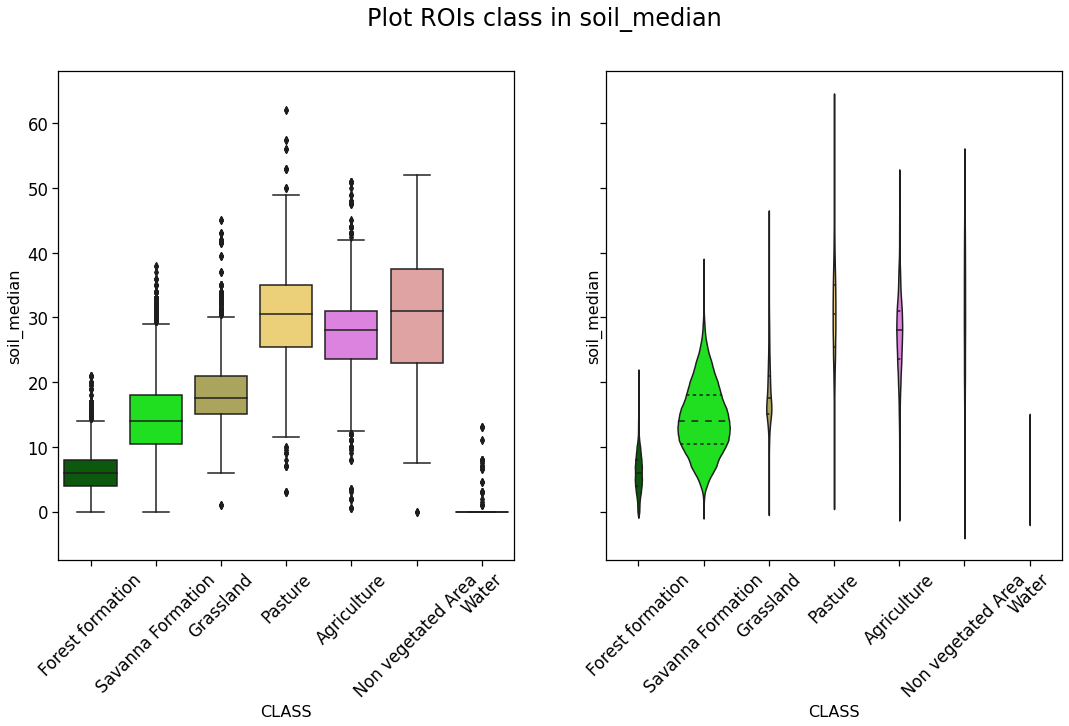

In [ ]:
for ii in range(10):
    numsort = randint(0, len(colunas_index) - 1)
    ploting_violin_rois_Class_index(colunas_index[numsort])

In [ ]:
X = concat_df[columns_features]
y = concat_df['class']

In [ ]:
X.shape

(130265, 94)

In [ ]:
porcentagemFeat = int(X.shape[1] * 0.3)
porcentagemFeat

28

In [ ]:
print(X.shape)
print(y.shape)

(130265, 94)
(130265,)


In [ ]:
# feature extraction
test = SelectKBest(score_func=f_classif, k=porcentagemFeat)

In [ ]:
fit_KBest = test.fit(X, y)

In [ ]:
# summarize scores
set_printoptions(precision= porcentagemFeat)
print(fit_KBest.scores_)
print(len(fit_KBest.scores_))

[26717.77257538588    22588.90323791011    30660.035598719634
 28051.97101883501    23298.569762505052   22303.33954502626
  3994.6926097098067   6458.127401925514    6755.939332858297
  5992.364649456918    6480.010222533383    1318.1675572225556
  4694.049519963529   12932.70800005611    10541.776086927652
  4516.528657606352   18566.774602973845   15343.001077399258
 19752.96741390162    31892.877136938052   31041.721587213367
  5435.250347310803   29948.286383203373    8993.874381755775
  4229.927404832328    9342.330443143279   13315.483497567033
  9936.501164951555   10925.49277793561     4043.316267353639
  4741.4735451825145  14646.313864078566   11461.868172543513
 19160.345294322084   11542.388943232616   31850.429511901053
 12074.054058369491    6187.273679640198   14529.931289921493
 10806.784506141232   21036.700247419172   10738.18520830528
  6082.838351170299   18506.854112379      15760.560448371798
 25774.3604952473      5122.753236710378   13617.322481777035
  9985.11

In [ ]:
list_ordenda = copy.deepcopy(fit_KBest.scores_)
list_ordenda =sorted(list_ordenda)
print(list_ordenda)
corte = int(len(list_ordenda) * 0.23)
print(corte)
valor_corte = list_ordenda[corte]
print("corte do core para importancia ", valor_corte)

[210.33643438539238, 1318.1675572225556, 1946.1690369850378, 2002.2191404342384, 2090.8375188265672, 2348.241198920839, 2359.5392476546144, 2796.1533616585775, 3690.39075360819, 3994.6926097098067, 4043.316267353639, 4117.49394310894, 4229.927404832328, 4438.641857959386, 4469.196722698055, 4516.528657606352, 4694.049519963529, 4710.970625640037, 4741.4735451825145, 5043.789350102244, 5075.03431673571, 5122.753236710378, 5435.250347310803, 5992.364649456918, 6082.838351170299, 6187.273679640198, 6289.223117505257, 6458.127401925514, 6480.010222533383, 6501.452115732291, 6661.384570747852, 6755.939332858297, 6970.378354298871, 8481.16295557686, 8993.874381755775, 9204.437981531197, 9342.330443143279, 9695.702840230302, 9936.501164951555, 9985.114048406918, 10541.776086927652, 10738.18520830528, 10745.198418465627, 10806.784506141232, 10925.49277793561, 11045.826552733093, 11319.991247720169, 11434.870972093955, 11461.868172543513, 11542.388943232616, 11770.488434007926, 12007.8790349805

In [ ]:
def print_blocos_5Feat(lst_features):
    text = ''
    for cc, col in enumerate(lst_features):
        if (cc + 1) % 5 == 0:
            print(text)
            text = ""

        else:
            text += '"' + str(col) + '",'

In [ ]:
list_feat_kbest = []
for cc, vv in enumerate(fit_KBest.scores_):
    if vv < valor_corte:
        list_feat_kbest.append(columns_features[cc])

print("lista de todas as features importantes pelo KBest \n")
print_blocos_5Feat(list_feat_kbest)
print("\n com {} features".format(len(list_feat_kbest)))

lista de todas as features importantes pelo KBest 

"cai_stdDev","cloud_stdDev","evi2_amp","evi2_stdDev",
"gv_stdDev","gvs_amp","nir_median_wet","npv_amp",
"npv_median_dry","npv_stdDev","pri_median","pri_median_dry",
"shade_amp","shade_max","shade_median_wet","shade_stdDev",

 com 21 features


In [ ]:
# feature extraction
model = LogisticRegression(solver='lbfgs')
rfe = RFE(model, n_features_to_select=porcentagemFeat, step=1)   # , porcentagemFeat
fit_RFE = rfe.fit(X, y)

/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/home/superuser/.local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-re

In [ ]:
fit_RFE.support_

array([False, False, False, False,  True,  True, False, False, False,
       False, False, False, False,  True, False, False,  True,  True,
        True, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
        True, False, False, False, False, False,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
       False, False, False, False, False, False, False, False,  True,
        True,  True, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False,  True,  True,  True, False,  True,
        True,  True, False, False])

In [ ]:
print(fit_RFE.ranking_)
print(len(fit_RFE.ranking_))

[17 11 19 20  1  1 21 63 64 62 65 67  4  1 10 14  1  1  1  5  2 27  8 23
 43 45 50 47 51 52 33 34 36 44 38 16  1 28 24 25 31 26  1  1  1  1  1  1
  1  1  1  1  1  1 57 55 58 56 59 66 22 18  1  1  1  6  3  9  7 15 29 42
 49 46 37 41 35 61 60 40 32 39 48 54 53  1  1  1 12  1  1  1 13 30]
94


In [ ]:
# list Feature importance
ls_Feat_importRFE = []
for cc, feat in enumerate(columns_features):
    if fit_RFE.support_[cc]:
        ls_Feat_importRFE.append(feat)


print("lista de todas as features importantes pelo REF \n")
print_blocos_5Feat(ls_Feat_importRFE)
print("\n com {} features".format(len(list_feat_kbest)))

lista de todas as features importantes pelo REF 

"cai_median","cai_median_dry","evi2_median","gcvi_median",
"gcvi_median_wet","hallcover_stdDev","ndvi_amp","ndvi_median",
"ndvi_median_wet","ndwi_amp","ndwi_median","ndwi_median_dry",
"nir_median","nir_median_dry","nir_median_wet","nir_min",
"red_median_dry","red_median_wet","swir1_median","swir1_median_wet",

 com 21 features


In [ ]:
from sklearn.ensemble import RandomForestClassifier

In [ ]:
classf_RF = RandomForestClassifier(
                            n_estimators=135,
                            max_features=25)
rfe = RFE(classf_RF, n_features_to_select=porcentagemFeat, step=1)
fit_rfe = rfe.fit(X, y)

In [ ]:
print("Selected Features: %s" % fit_rfe.support_)

In [ ]:
print("Num Features: %d" % fit.n_features_)
print("Selected Features: %s" % fit.support_)
print("Feature Ranking: %s" % fit.ranking_)

Num Features: 23
Selected Features: [False False False False False False False False False False False False
 False False False  True False False False False False False False False
  True  True  True False False False  True  True  True False  True False
 False False False False False False  True  True  True  True  True  True
 False False False  True False False  True  True  True  True  True  True
 False False False False  True  True False False False False False False
 False False False False False False]
Feature Ranking: [38 40 44 37 36 41 43 34 30 27 26 33  2 15  3  1  9  8 16 10 18 23 20 22
  1  1  1 24 29 32  1  1  1  7  1  6 25 28 31 12 14 13  1  1  1  1  1  1
 35 39 42  1 11  5  1  1  1  1  1  1 17 21 19  4  1  1 52 50 53 45 46 47
 49 48 51 56 55 54]


In [ ]:
# list Feature importance
ls_Feat_import = []
for cc, feat in enumerate(columns_features):
    if fit.support_[cc]:
        ls_Feat_import.append(feat)

print(ls_Feat_import)


['nir_1', 'ndwi', 'ndwi_median', 'ndwi_median_dry', 'awei', 'awei_median', 'awei_median_dry', 'ndvi_median', 'lai', 'lai_median', 'lai_median_dry', 'osavi', 'osavi_median', 'osavi_median_dry', 'gcvi', 'brightness', 'brightness_median', 'brightness_median_dry', 'ratio', 'ratio_median', 'ratio_median_dry', 'wetness_median', 'wetness_median_dry']


In [ ]:
novas_features = np.unique(list_feat_kbest + ls_Feat_import)
novas_features

array(['awei', 'awei_median', 'awei_median_dry', 'brightness',
       'brightness_median', 'brightness_median_dry', 'cvi_median_dry',
       'gcvi', 'gv_median', 'gv_median_dry', 'lai', 'lai_median',
       'lai_median_dry', 'ndfia', 'ndfia_median', 'ndfia_median_dry',
       'ndvi_median', 'ndwi', 'ndwi_median', 'ndwi_median_dry', 'nir_1',
       'npv', 'npv_median', 'npv_median_dry', 'osavi', 'osavi_median',
       'osavi_median_dry', 'ratio', 'ratio_median', 'ratio_median_dry',
       'soil', 'soil_median', 'soil_median_dry', 'spri', 'spri_median',
       'wetness_median', 'wetness_median_dry'], dtype='<U21')

In [ ]:
lista_Feat_final = [kk for kk in novas_features]
print("numero de Features ", len(lista_Feat_final))
print(lista_Feat_final)

numero de Features  37
['awei', 'awei_median', 'awei_median_dry', 'brightness', 'brightness_median', 'brightness_median_dry', 'cvi_median_dry', 'gcvi', 'gv_median', 'gv_median_dry', 'lai', 'lai_median', 'lai_median_dry', 'ndfia', 'ndfia_median', 'ndfia_median_dry', 'ndvi_median', 'ndwi', 'ndwi_median', 'ndwi_median_dry', 'nir_1', 'npv', 'npv_median', 'npv_median_dry', 'osavi', 'osavi_median', 'osavi_median_dry', 'ratio', 'ratio_median', 'ratio_median_dry', 'soil', 'soil_median', 'soil_median_dry', 'spri', 'spri_median', 'wetness_median', 'wetness_median_dry']


In [ ]:
clf = RandomForestClassifier(n_estimators=225, max_depth=25, min_samples_split=20, random_state=0)
clf.fit(X_train[columnaTraining], y_train)
y_pred = clf.predict(X_test[columnaTraining])

In [ ]:
matrix = confusion_matrix(y_test, y_pred)
matrix

In [ ]:
plot_confusion_matrix(clf, X_test[columnaTraining], y_test)
plt.show()